In [ ]:
# Modified approach with train/test split and different segment sizes
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and scale data (Data preprocessing)
yahoo_df = pd.read_csv('/content/sample_data/yahoo_1.csv', header=None)
yahoo_values = yahoo_df.values.ravel()
scaler = MinMaxScaler()
scaled_yahoo = scaler.fit_transform(yahoo_values.reshape(-1, 1)).flatten()

# Use 70% for training, 30% for testing (Data Preparation)
train_size = int(0.7 * len(scaled_yahoo))
train_data = scaled_yahoo[:train_size]
test_data = scaled_yahoo[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

# Try different segment sizes for better clustering
segment_sizes = [50, 100, 200]  # Smaller segments might capture more patterns

for segment_length in segment_sizes:
    print(f"\n=== Segment Length: {segment_length} ===")

    # Extract training features
    train_segments = []
    for i in range(0, len(train_data) - segment_length + 1, segment_length//2):  # 50% overlap
        segment = train_data[i:i + segment_length]
        features = [
            np.mean(segment),
            np.std(segment),
            np.max(segment),
            np.min(segment),
            np.sum(segment > 0.7),  # spikes
            np.sum(segment > 0.5),  # medium peaks
            len(segment[segment > np.mean(segment) + np.std(segment)])  # outliers
        ]
        train_segments.append(features)

    train_features = np.array(train_segments)

    # Try different number of clusters (hyperparameter tuning)
    for n_clusters in [3, 5, 7]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        train_labels = kmeans.fit_predict(train_features)

        if len(np.unique(train_labels)) > 1:
            sil_score = silhouette_score(train_features, train_labels)
            print(f"Clusters: {n_clusters}, Silhouette: {sil_score:.3f}")


Training data size: 993
Testing data size: 427

=== Segment Length: 50 ===
Clusters: 3, Silhouette: 0.496
Clusters: 5, Silhouette: 0.548
Clusters: 7, Silhouette: 0.618

=== Segment Length: 100 ===
Clusters: 3, Silhouette: 0.447
Clusters: 5, Silhouette: 0.407
Clusters: 7, Silhouette: 0.456

=== Segment Length: 200 ===
Clusters: 3, Silhouette: 0.372
Clusters: 5, Silhouette: 0.457
Clusters: 7, Silhouette: 0.146


In [ ]:
# More sophisticated feature extraction
def extract_enhanced_features(segment):
    """Extract more comprehensive features from time series segment"""
    features = []

    # Statistical features
    features.extend([
        np.mean(segment),
        np.std(segment),
        np.max(segment),
        np.min(segment),
        np.median(segment),
        np.percentile(segment, 75) - np.percentile(segment, 25),  # IQR
        len(segment[segment > np.mean(segment) + 2*np.std(segment)])  # strong outliers
    ])

    # Trend features
    x = np.arange(len(segment))
    slope = np.polyfit(x, segment, 1)[0]  # linear trend
    features.append(slope)

    # Peak detection features
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(segment, height=0.5)
    features.append(len(peaks))  # number of peaks

    # Frequency domain features (simplified)
    fft_vals = np.fft.fft(segment)
    features.append(np.mean(np.abs(fft_vals[:len(fft_vals)//2])))  # mean frequency magnitude

    return features

# Apply enhanced feature extraction
enhanced_segments = []
for i in range(0, len(train_data) - segment_length + 1, segment_length//2):
    segment = train_data[i:i + segment_length]
    features = extract_enhanced_features(segment)
    enhanced_segments.append(features)

enhanced_features = np.array(enhanced_segments)


In [ ]:
# Apply PCA for dimensionality reduction before clustering
from sklearn.decomposition import PCA

# Standardize features first
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(enhanced_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
reduced_features = pca.fit_transform(scaled_features)

print(f"Original features: {enhanced_features.shape[1]}")
print(f"Reduced features: {reduced_features.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Cluster on reduced features
kmeans_pca = KMeans(n_clusters=4, random_state=42)
pca_labels = kmeans_pca.fit_predict(reduced_features)


Original features: 10
Reduced features: 2
Explained variance: 0.967


In [ ]:
# Evaluate predictions on test data
def evaluate_clustering_prediction(train_features, train_labels, test_data, segment_length, kmeans_model, feature_scaler, pca_model):
    """Comprehensive evaluation of clustering predictions"""

    # Extract test features
    test_segments = []
    for i in range(0, len(test_data) - segment_length + 1, segment_length):
        segment = test_data[i:i + segment_length]
        features = extract_enhanced_features(segment)
        test_segments.append(features)

    test_features = np.array(test_segments)

    # Apply same preprocessing
    scaled_test_features = feature_scaler.transform(test_features)
    reduced_test_features = pca_model.transform(scaled_test_features)

    # Predict clusters
    test_predictions = kmeans_model.predict(reduced_test_features)

    # Calculate prediction confidence (distance to cluster centers)
    distances = kmeans_model.transform(reduced_test_features)
    min_distances = np.min(distances, axis=1)
    confidence_scores = 1 / (1 + min_distances)  # Higher = more confident

    return test_predictions, confidence_scores, test_features

# Run evaluation
test_predictions, confidence_scores, test_features = evaluate_clustering_prediction(
    reduced_features, pca_labels, test_data, segment_length,
    kmeans_pca, feature_scaler, pca
)

print(f"Test predictions: {test_predictions}")
print(f"Average confidence: {np.mean(confidence_scores):.3f}")
print(f"Prediction distribution: {np.bincount(test_predictions)}")


Test predictions: [1 1]
Average confidence: 0.683
Prediction distribution: [0 2]


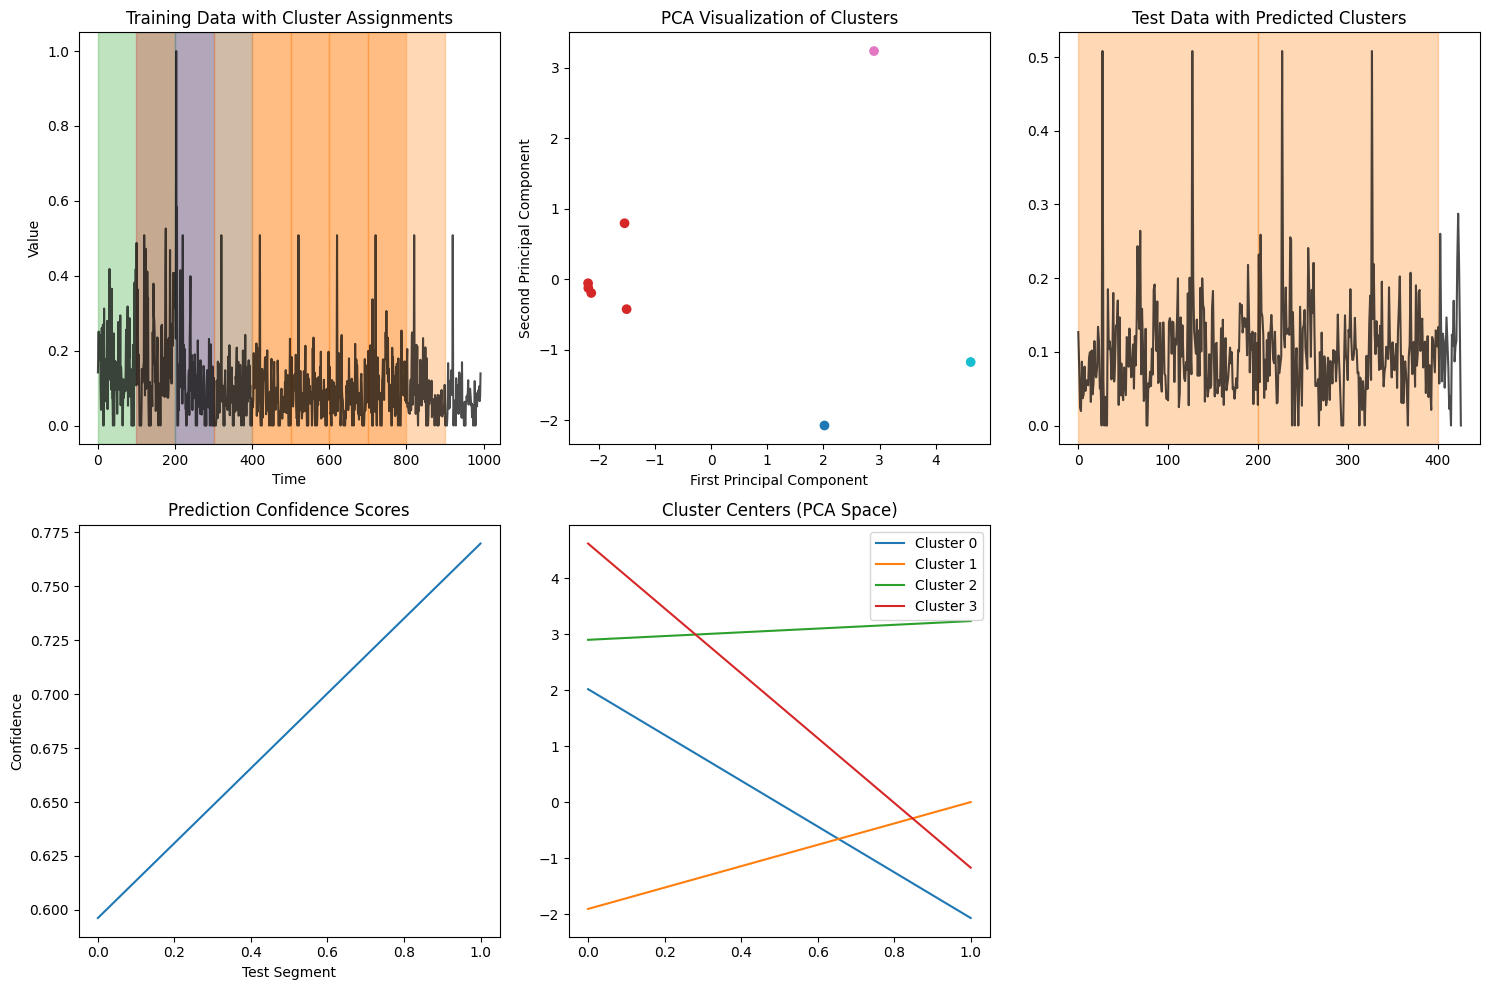


=== FINAL RESULTS ===
Training silhouette score: 0.525
Number of test segments: 2
Cluster distribution in test: {np.int32(1): np.int64(2)}
Average prediction confidence: 0.683


In [ ]:
# Visualize clustering results
plt.figure(figsize=(15, 10))

# Plot 1: Original time series with cluster assignments
plt.subplot(2, 3, 1)
segment_starts = range(0, len(train_data) - segment_length + 1, segment_length//2)
colors = plt.cm.tab10(pca_labels)
for i, (start, color) in enumerate(zip(segment_starts, colors)):
    plt.axvspan(start, start + segment_length, alpha=0.3, color=color)
plt.plot(train_data, 'k-', alpha=0.7)
plt.title('Training Data with Cluster Assignments')
plt.xlabel('Time')
plt.ylabel('Value')

# Plot 2: PCA visualization
plt.subplot(2, 3, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=pca_labels, cmap='tab10')
plt.title('PCA Visualization of Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 3: Test predictions
plt.subplot(2, 3, 3)
test_segment_starts = range(0, len(test_data) - segment_length + 1, segment_length)
test_colors = plt.cm.tab10(test_predictions)
for i, (start, color) in enumerate(zip(test_segment_starts, test_colors)):
    plt.axvspan(start, start + segment_length, alpha=0.3, color=color)
plt.plot(test_data, 'k-', alpha=0.7)
plt.title('Test Data with Predicted Clusters')

# Plot 4: Confidence scores
plt.subplot(2, 3, 4)
plt.plot(confidence_scores)
plt.title('Prediction Confidence Scores')
plt.xlabel('Test Segment')
plt.ylabel('Confidence')

# Plot 5: Cluster centers comparison
plt.subplot(2, 3, 5)
for i in range(len(kmeans_pca.cluster_centers_)):
    plt.plot(kmeans_pca.cluster_centers_[i], label=f'Cluster {i}')
plt.title('Cluster Centers (PCA Space)')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== FINAL RESULTS ===")
print(f"Training silhouette score: {silhouette_score(reduced_features, pca_labels):.3f}")
print(f"Number of test segments: {len(test_predictions)}")
print(f"Cluster distribution in test: {dict(zip(*np.unique(test_predictions, return_counts=True)))}")
print(f"Average prediction confidence: {np.mean(confidence_scores):.3f}")
